Non-stationary Transformers:  https://t.co/HoFxmHoaT2   
Probabilistic Time Series Forecasting with Transformers: https://huggingface.co/blog/time-series-transformers   
Stock Embeddings for Portfolios: https://t.co/YuK5u8gXHz   
Multi-Order Dynamics and Internal Dynamics in Stock Movement: https://t.co/wyuva2EnG3  
Tree-Based Local Volatility Surface: https://impa.br/wp-content/uploads/2018/10/projetos_fim_curso_yuri_resende_fonseca.pdf   
Random Forests and Boosting for ARCH-like volatility forecasts: https://www.sarem-seitz.com/random-forests-and-boosting-for-arch-like-volatility-forecasts/     
Deep Learning For Time Serie Forecasting: Tutorial and Literatue Survey.  https://arxiv.org/pdf/2004.10240.pdf   

The Effectiveness of Discretization in Forecasting: An Empirical Study on Neural Time Series Models. https://arxiv.org/abs/2005.10111    
https://arxiv.org/abs/1809.04356       
https://arxiv.org/pdf/2102.12658.pdf     
https://arxiv.org/abs/2012.12485      
https://arxiv.org/pdf/2004.10240.pdf    


Modeling time series at a large scale is challenging and resource-intensive. Most of the classical literature is devoted to univariate, either heteroscedasticity or homoscedasticity, and multivariate, where the joint covariance among distinct realizations is a matter of study; however, with unclear limitations about the volume. Deep Learning raises a trailblazing proposal for scaling it up. Thus, in this chapter, we introduce global big models for time series with DL.

As with the others, this notebook is a personal summary of excellent papers, the aforementioned ones. If you need clarification or deeper details, please reach out to the bare references.     


--------

##### The Deep Learning Era

Deep Learning is a game-changer in many areas, such as Computer Vision and NLP. By 2006, (Hinton et al) presented to the world a feasible footstep for training Neural Networks with a large number of layers - if, and only if, initial weights are set adequately. Nowadays, DL is a ubiquitous solution, even in Forecast solutions - indeed, owing to its traits, they are a fruitful field for DL.

Before dwelling on the literature and candidate models, we shed light on the cornerstone of time series: stationarity. Distribution-varying time series realization makes deep learning models intractable. Therefore, applying pre-processing data for deep model inputs is a standard approach [1]. To cite a few: Z-score normalization, DAIN, RevIN, and the attention mechanism proposed by [1].

[1] Non-stationary Transformers: Exploring the Stationarity in Time Series Forecasting. https://arxiv.org/pdf/2205.14415.pdf

Read dataset for analysis.

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

mglu = pd.read_csv('MGLU3_historical_data.csv')

mglu['Date'] = pd.to_datetime(mglu['Date'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


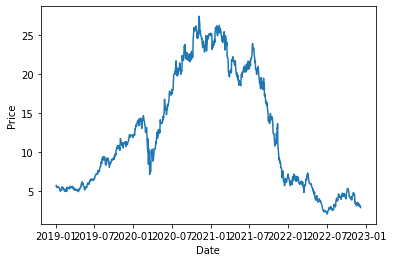

In [ ]:
sns.lineplot('Date', 'Price', data=mglu)

To develop intuition on stationarity treatment, we can leverage RevIN official implementation of RevIN is available on GitHub: https://github.com/ts-kim/RevIN

In [ ]:
import torch
import torch.nn as nn

class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x


In [ ]:
x_in = torch.tensor(mglu['Price'].values)
revin_layer = RevIN(len(x_in))
x_in = revin_layer(x_in, 'norm')

In [ ]:
mglu['Price_Norm'] = x_in.tolist()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


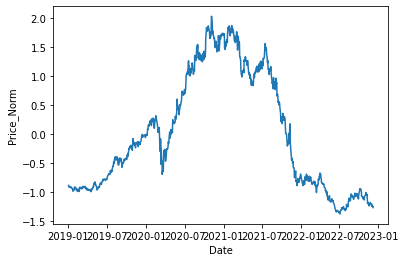

In [ ]:
sns.lineplot('Date', 'Price_Norm', data=mglu)

#### Deep candidate models   


Tailoring architecture is one of the foremost traits of Deep Neural Networks. Usual proposals, such as Convolutional NN, and Recurrent NN, are suitable picks for specific problems. Regarding time-series modeling, RNN-based and Seq-2-Seq architectures are canonical picks due to their ability to relate a current observation, at time $t$, upon its past realizations. Contemporary architectures, such as Transformers and GAN, have gained attention(joke alert) as feasible solutions, either. Before move on, we recap those architectures.    



* RNN.
Recurrent NN is a kind of NN that fit and predict wired on hidden states and past observations in an autoregressive fashion. As vanishing gradient is a shortcoming of big RNN, researchers proposed the LSTM.

https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks    
https://www.sciencedirect.com/topics/computer-science/recurrent-neural-network    
https://d2l.ai/chapter_recurrent-modern/lstm.html    

* Seq2Seq.   
The S2S architecture blends two NN in tandem, on a enconding-decoding shape. The decoding shape is predetermiend, and its loss is computed against the actual values.

#### Literature review  


In this section, we underscore some great candidate/possible models, drilled down by `probabilistic forecast`, `point forecast`, `global-local models`, `intermittent time series`. As it follows, We summarize every specific domain application wiil be properly summarized.    

`Point forecast` models output only one single value; the best output to the actual realization. 

`Probability forecasts` are extensions for `Point forecast`, whose point forecast are parameters of a `probability model`. A non-parametric version of it returns quantils of a unknown probability model, a.k.a `quantile forecast`.

`Global-local`. `Local` Models learn free parameters of a specific time-series. Classical remarkable local time-series are ARIMA, ETS. Whereas in `Global` models, free parameters are learned jointly on every series. Global-Local conjugate the best of both worlds. Statistical Mixed models stand out as a great solution, DNN has raised as trailblazing proposals for G-L models. 

`Intermittent Series` epitomises time-series with empty values, or zeros, for a large volume of realizations throughout time. This trait inflicts big challenges on classical time-series modeling.


-----
##### Probabilistc Forecast  
1. One-step forecast

  * DeepAR model is a global univariate that can learn multivariate distribution.   
  * TimeGrad is a RNN using LSTM.

2. Multi-step forecast.

  * MQRNN/MQCNN are a seq2seq architecture for multi-step forecast, which produces multi-predictions at one. 
  * "Deep generative quantile-copula models for probabilistic forecasting" extended the MQCNN model with a generative quantile copula. This model learns the conditional quantile function that maps the quantile index, which is a uniform random variable conditioned on the
covariates, to the target.   
  * DeepTCN, another seq2seq model where the encoder is the dilated causal convolution with residual blocks, and the decoder is simply an MLP with residual connections.   
  *  Learning quantile functions without quantile crossing for distribution-free time series forecasting" propose the incremental quantile functions (IQF), a flexible and efficient distribution-free quantile estimation framework that resolves quantile crossing with a simple NN layer.


-----
##### Point Forecast
1. One-step forecast.
  * LSTNet.   
  * DeepAr.

2. Multi-step forecast.
  * N-BEATS.   
  * Stacked autoencoder.   
  * Diffusion Convolutional Recurrent NN.   
  * Position-based content attention for time series forecasting with sequence-to-sequence RNNs proposed a content attention mechanism that seats on top of any seq2seq RNN.   
  * Enhancing the locality and breaking the memory bottleneck of transformer on time series forecasting. introduce two modifications to the Transformer architecture to improve its performance for forecasting.   
  * Temporal Fusion Transformer (TFT).    
  * MQ-Transformer.   
  * Informer, a computationally efficient Transformer architecture,
that specifically targets applications with long forecast horizons.


-----
##### Global-local      
* Deep Factors.   
* Deep Global Local Forecaster.   


-----
##### Intermittent Time Series      
* RNN architecture with a negative binomial likelihood to handle intermittent demand.    
* Joint modeling of event sequence and time series with attentional twin recurrent neural networks.      



GluonTS is a tremendous Python library for Deep Learning Time Series. In two distinct moments, I'll attempt training local and global models. 

In [1]:
!pip install gluonts mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
# %#matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.8/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers']


In [5]:
meta, train_ds, test_ds = get_dataset("electricity")

In [9]:
next(iter(train_ds))

{'target': array([14., 18., 21., ...,  6.,  9.,  7.], dtype=float32),
 'start': Period('2012-01-01 00:00', 'H'),
 'feat_static_cat': array([0], dtype=int32),
 'item_id': 0}

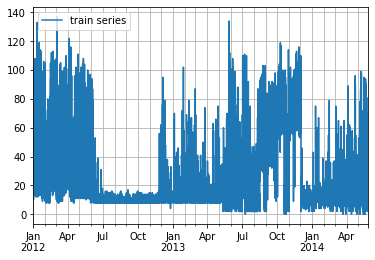

In [10]:
entry_train = next(iter(train_ds))
train_series = to_pandas(entry_train)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

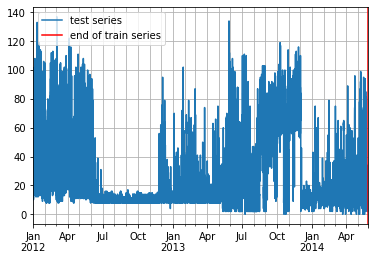

In [11]:
entry_test = next(iter(test_ds))
test_series = to_pandas(entry_test)
test_series.plot()
plt.axvline(train_series.index[-1], color="r")  # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [31]:
meta.prediction_length

24

In [12]:
print(
    f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}"
)
print(f"Recommended prediction horizon: {meta.prediction_length}")
print(f"Frequency of the time series: {meta.freq}")

Length of forecasting window in test dataset: 24
Recommended prediction horizon: 24
Frequency of the time series: 1H


In [15]:
from gluonts.mx import DeepAREstimator, Trainer

estimator = DeepAREstimator(
    freq=meta.freq,
    prediction_length=meta.prediction_length,
    context_length=100,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1e-3, num_batches_per_epoch=100),
)

In [59]:
predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:51<00:00,  1.94it/s, epoch=5/5, avg_epoch_loss=5.34]


In [23]:
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import backtest_metrics

evaluator = Evaluator(quantiles=(0.1, 0.5, 0.9))

agg_metrics, item_metrics = backtest_metrics(
    test_dataset=test_ds,
    predictor=predictor,
    evaluator=evaluator
)

Running evaluation: 100%|██████████| 2247/2247 [01:57<00:00, 19.07it/s]
/usr/local/lib/python3.8/dist-packages/pandas/core/dtypes/cast.py:1201: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [24]:
agg_metrics

{'MSE': 3175913.722327275,
 'abs_error': 9367631.754647255,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.8477963400481334,
 'MAPE': 0.11189441424005425,
 'sMAPE': 0.11534020843772096,
 'MSIS': 7.007853352141448,
 'QuantileLoss[0.1]': 3762416.7409806335,
 'Coverage[0.1]': 0.14348761311378133,
 'QuantileLoss[0.5]': 9367631.760589771,
 'Coverage[0.5]': 0.6960762498145675,
 'QuantileLoss[0.9]': 6829557.5293075945,
 'Coverage[0.9]': 0.9313900014834593,
 'RMSE': 1782.1093463441784,
 'NRMSE': 0.7471304074645447,
 'ND': 0.07282450816606637,
 'wQuantileLoss[0.1]': 0.029249244190428413,
 'wQuantileLoss[0.5]': 0.07282450821226383,
 'wQuantileLoss[0.9]': 0.053093373126771606,
 'mean_absolute_QuantileLoss': 6653202.010292667,
 'mean_wQuantileLoss': 0.05172237517648795,
 'MAE_Coverage': 0.43139000148345924,
 'OWA': nan}

In [54]:
from gluonts.evaluation import make_evaluation_predictions

In [60]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [61]:
%%time

forecasts = list(forecast_it)
tss = list(ts_it)

CPU times: user 2min 14s, sys: 5.45 s, total: 2min 19s
Wall time: 2min 2s


In [63]:
forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2014-05-26 20:00
Frequency of the time series: <Hour>


In [64]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 9.155737   13.032604    9.290893   12.256549   10.159325   15.086522
 15.908233   16.148623   18.688017   15.673288   17.083403   13.145193
 24.637833   19.07144     8.877104   13.720532   14.381177   12.17157
  6.1696253   7.754944   -0.8059538   0.9282933  -0.16513032 -0.5444015 ]
0.5-quantile (median) of the future window:
 [ 9.250178   12.717841    9.015887   12.487144    9.512491   15.107957
 15.966493   16.543777   18.482405   17.264082   16.849606   12.670554
 23.790648   17.853964    9.35412    13.809608   14.372154   12.677524
  6.0235915   6.9708185  -0.81890774  0.8928909   0.19082673 -1.1328983 ]


In [69]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
  
ts_entry = tss[0]

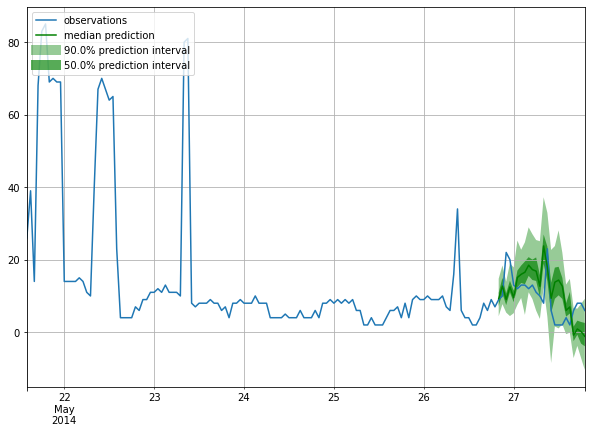

In [70]:
plot_prob_forecasts(ts_entry, forecast_entry)